---
# EAPS 50700 Final Project

Do synoptic snow events have lower SLR than lake effect events?

Case Study Dates
Synoptic events:
- S/Central IN. February 14-16 2021 https://www.weather.gov/ind/Feb15WinterStorm#:~:text=A%20large%20synoptic%20system%20brought,12%20inches%20across%20the%20area. 
- N/Central IN. February 24-25 2016. https://www.weather.gov/iwx/2016022425_snow. 

Lake effect events:
- N. IN. January 19-20, 2024.  https://www.weather.gov/iwx/01192024_lakeeffectsnow.

- N. IN. January 6-7 2022. https://www.weather.gov/iwx/LakeEffect_2022Jan6-7. 


Data Sources
- ERA 5
- Sfc obs

---
Import Packages

In [7]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches 
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.patches as patches
import pandas as pd
from scipy.interpolate import griddata
import glob
import os


---
Define a function to clean our xmacsi2 data

In [9]:
# This function removes spaces in column names and variable entries
def prep_df(dff):
    
    
    dff.columns = dff.columns.str.strip() # strip leading spaces in column names
    dff = dff.map(lambda x: x.strip() if isinstance(x, str) else x) # strip spaces from values
    mask = (dff['Snowfall'].isin(['M', 'T','S'])) | (dff['Precipitation'].isin(['M', 'T','S']) ) # get rid of missing or trace values
    dff = dff[~mask]

    dff['Precipitation'] = dff['Precipitation'].str.replace(r'A', '', regex=True) # remove erroneous 'A's' in precip
    
    # make precip and snowfall float 
    dff[['Precipitation','Snowfall']] = dff[['Precipitation','Snowfall']].map(lambda x: float(x) if isinstance(x, str) else x)
    
   
    # just keep variables we are interested in 
    dff = dff[['Latitude', 'Longitude', 'Precipitation', 'Snowfall']]

    # sum precip and snowfall across the event at each location where applicable
    dff = dff.groupby(['Latitude', 'Longitude'], as_index=False).sum()

    # calculate SLR
    dff['SLR'] = dff['Snowfall'] / dff['Precipitation']

    # remove SLR >48
    dff = dff.loc[dff['SLR'] <= 48]

    return dff # return clean data



---
set paths and read in data

In [10]:
root = "C:/Users/Zac/Desktop/FALL 2024/50700 - data science/Project/snow_data/"
xm_root = "C:/Users/Zac/Desktop/FALL 2024/50700 - data science/Project/xmacis_data/"

#synoptic 1 files: FEB 14-16 2021
synoptic_1 = 'synoptic_snow_feb2021.nc'
df_S1_path = 'synoptic_1'
df_L1_path = 'LES_1'
#LES 1 files: 
LES_1 = 'LES.nc'

#synoptic 2 files:
synoptic_2 = "synotpic2.nc"

#LES 2 files
LES_2 = "LES2.nc"

ds_S1 = xr.open_dataset(root+synoptic_1)
df_s1_1 = pd.read_csv(xm_root+"synoptic_1/synoptic1_FEB14_21.csv")
df_s1_2 = pd.read_csv(xm_root+"synoptic_1/synoptic1_FEB15_21.csv")
df_s1_3 = pd.read_csv(xm_root+"synoptic_1/synoptic1_FEB16_21.csv")


ds_L1 = xr.open_dataset(root+LES_1)
df_L1_1 = pd.read_csv(xm_root+"LES_1/LES1_JAN_19_24.csv")
df_L1_2 = pd.read_csv(xm_root+"LES_1/LES1_JAN_20_24.csv")

ds_S2 = xr.open_dataset(root+synoptic_2, engine = 'h5netcdf')
ds_L2 = xr.open_dataset(root+LES_2, engine = 'h5netcdf')

---
combine data from all days in event

In [11]:
# Specify the directory containing the CSV files
directory_path_S1 = xm_root+df_S1_path  # Replace with your directory path

# Use glob to get all the CSV files in the directory
csv_files = glob.glob(os.path.join(directory_path_S1, '*.csv'))

# Read and concatenate all CSV files into a single DataFrame
df_list = [pd.read_csv(file) for file in csv_files]
combined_df_S1 = prep_df(pd.concat(df_list, ignore_index=True))

In [4]:
# Specify the directory containing the CSV files
directory_path_L1 = xm_root+df_L1_path  # Replace with your directory path

# Use glob to get all the CSV files in the directory
csv_files = glob.glob(os.path.join(directory_path_L1, '*.csv'))

# Read and concatenate all CSV files into a single DataFrame
df_list = [pd.read_csv(file) for file in csv_files]
combined_df_L1 = prep_df(pd.concat(df_list, ignore_index=True))

---
define a function to grid data so we can plot it

In [5]:
# this function gets out data ready to plot by interpolating data onto a grid
def plotable(df):# Create a grid for the contour plot
    grid_latitude = np.linspace(df['Latitude'].min(), df['Latitude'].max(), 100)
    grid_longitude = np.linspace(df['Longitude'].min(), df['Longitude'].max(), 100)
    grid_longitude, grid_latitude = np.meshgrid(grid_longitude, grid_latitude)

    # Interpolate the values onto the grid
    grid_value = griddata((df['Longitude'], df['Latitude']), df['SLR'], 
                        (grid_longitude, grid_latitude), method='nearest')

    return grid_latitude, grid_longitude, grid_value

---
plot stations

Text(0.5, 1.0, 'Station Points to Calculate SLR')

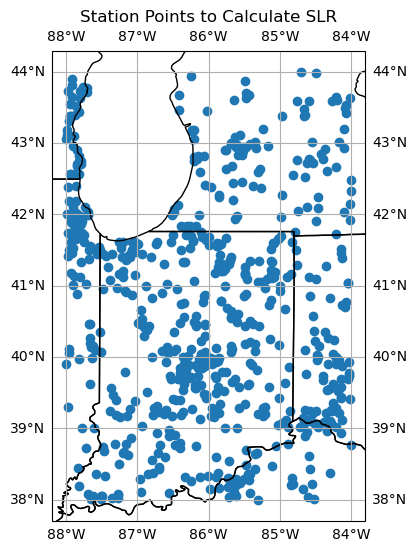

In [13]:
fig,ax = plt.subplots(figsize=(4, 5), subplot_kw={'projection': ccrs.PlateCarree()})
fig.tight_layout()

latmin_n = 20
latmax_n = 70
lonmin_n = -160
lonmax_n = -60
extent = [lonmin_n,lonmax_n,latmin_n,latmax_n]

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=1)
ax.add_feature(cfeature.STATES, linestyle='-', alpha=1)
ax.gridlines(draw_labels=True)
ax.scatter(combined_df_S1['Longitude'], combined_df_S1['Latitude'])

plt.title('Station Points to Calculate SLR')

---
# plot SLR synoptic 1

In [16]:
print(f' Mean SLR from Synoptic Event 1: {combined_df_S1.SLR.mean():.0f}')

 Mean SLR from Synoptic Event 1: 15


Text(0.5, 1.0, 'SLR 14-16 FEB 2021')

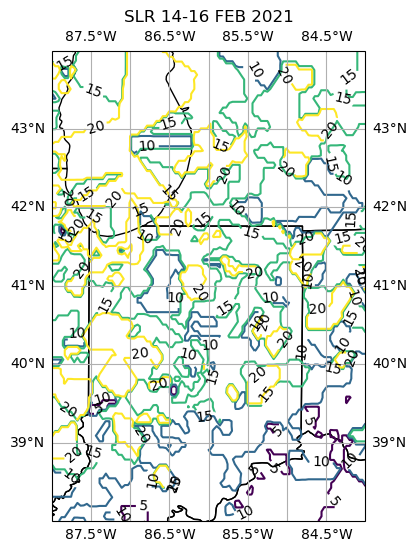

In [18]:
fig,ax = plt.subplots(figsize=(4, 5), subplot_kw={'projection': ccrs.PlateCarree()})
fig.tight_layout()
grid_lat, grid_lon, grid_values = plotable(combined_df_S1)
latmin_n = 20
latmax_n = 70
lonmin_n = -160
lonmax_n = -60
extent = [lonmin_n,lonmax_n,latmin_n,latmax_n]

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=1)
ax.add_feature(cfeature.STATES, linestyle='-', alpha=1)
ax.gridlines(draw_labels=True)
contour = ax.contour(grid_lon, grid_lat, grid_values, cmap='viridis',levels = np.arange(5,25,5))

ax.clabel(contour, inline = True,colors = 'black')
plt.title('SLR 14-16 FEB 2021')


---
Plot SLR LES 1

In [19]:
print(f' Mean SLR from LES Event 1: {combined_df_L1.SLR.mean():.0f}')

 Mean SLR from LES Event 1: 17


Text(0.5, 1.0, 'SLR 19-20 JAN 2024')

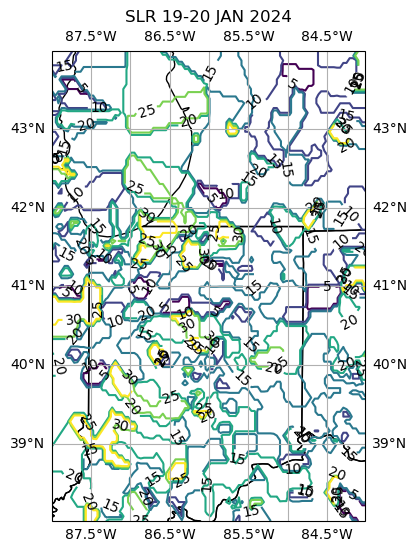

In [20]:
fig,ax = plt.subplots(figsize=(4, 5), subplot_kw={'projection': ccrs.PlateCarree()})
fig.tight_layout()
grid_lat, grid_lon, grid_values = plotable(combined_df_L1)
latmin_n = 20
latmax_n = 70
lonmin_n = -160
lonmax_n = -60
extent = [lonmin_n,lonmax_n,latmin_n,latmax_n]

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=1)
ax.add_feature(cfeature.STATES, linestyle='-', alpha=1)
ax.gridlines(draw_labels=True)
contour = ax.contour(grid_lon, grid_lat, grid_values, cmap='viridis',levels = np.arange(5,35,5))

ax.clabel(contour, inline = True, colors = 'black')
plt.title('SLR 19-20 JAN 2024')


---
# Work with ERA5 data

---
Calculate Average Snow Density

In [8]:
dense_av_S1 = ds_S1.rsn.mean(dim = 'valid_time' )
dense_av_L1 = ds_L1.rsn.mean(dim = 'valid_time' )
dense_av_S2 = ds_S2.rsn.mean(dim = 'valid_time' )
dense_av_L2 = ds_L2.rsn.mean(dim = 'valid_time' )



---
Filter data for times in event outlined by NWS

In [9]:
ds_S1 = ds_S1.sel(valid_time = ds_S1.valid_time.dt.day >= 14)
ds_L1 = ds_L1.sel(valid_time = ds_L1.valid_time.dt.day >= 6)
ds_S2 = ds_S2.sel(valid_time = ds_S2.valid_time.dt.day >= 24)
ds_L2 = ds_L2.sel(valid_time = ds_L2.valid_time.dt.day >= 6)

---
calculate new snow depth (accumulated snow): (snow depth at time = 0) - (snow depth at time = Tf)

In [11]:
sd_S1 = ds_S1.sd[len(ds_S1)] - ds_S1.sd[0] 
sd_L1 = ds_L1.sd[len(ds_L1)] - ds_L1.sd[0] 
sd_S2 = ds_S2.sd[len(ds_S2)] - ds_S2.sd[0] 
sd_L2 = ds_L2.sd[len(ds_L2)] - ds_L2.sd[0] 

---
Convert from liquid equivalent to actual snow accumulation.

new snowfall * snow density * inch conversion

In [13]:
snow_S1 = (sd_S1* dense_av_S1)* 39.3701
snow_L1 = (sd_L1* dense_av_L1)* 39.3701
snow_S2 = (sd_S2* dense_av_S2)* 39.3701
snow_L2 = (sd_L2* dense_av_L2)* 39.3701

In [47]:
def filter_6in(snow_ds):
    mask = snow_ds.where(snow_ds > 6.)
    
    return mask

In [96]:
def filter_grid(ds):
    latmin_b = 38.75
    latmax_b = 38.5
    lonmin_b = -85.25
    lonmax_b = -85

    ds_grid = ds.sel(latitude = slice(latmin_b,latmax_b), longitude = slice(lonmin_b,lonmax_b))

    return(ds_grid)

# Visual reference of XMascis2 data grab
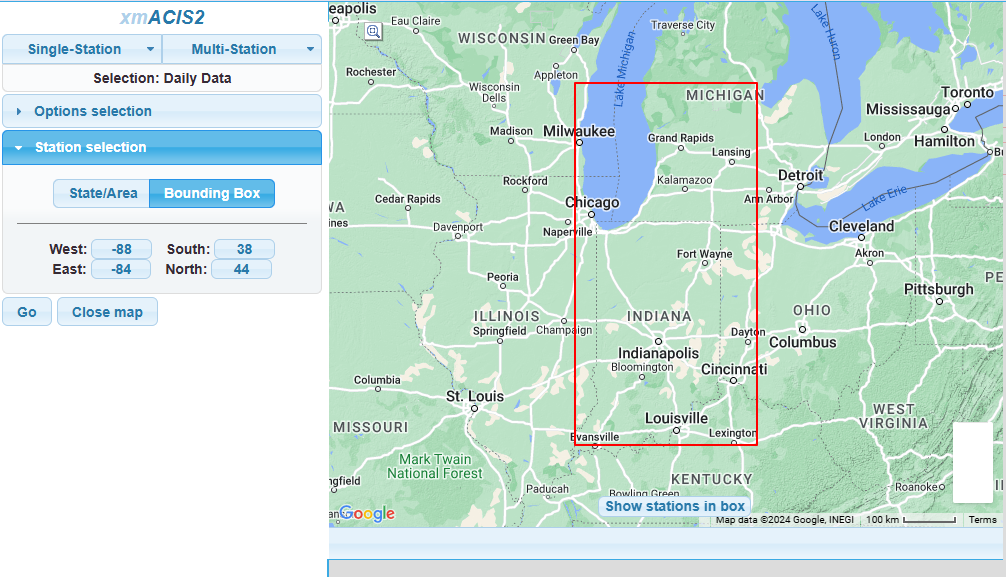

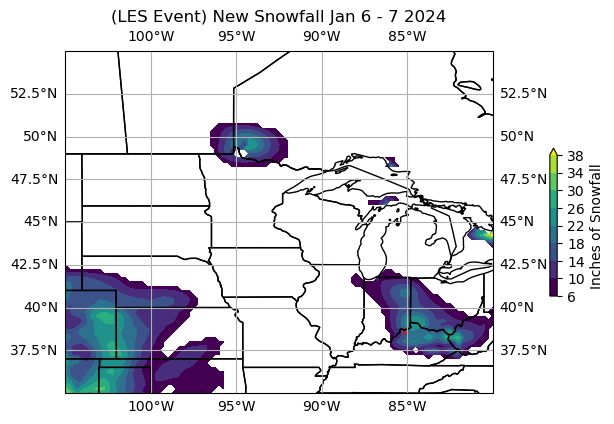

In [89]:
fig,ax = plt.subplots(figsize=(6, 4), subplot_kw={'projection': ccrs.PlateCarree()})
fig.tight_layout()
latmin_n = 20
latmax_n = 70
lonmin_n = -160
lonmax_n = -60

latmin_b = 38.75
latmax_b = 38.5
lonmin_b = -85.25
lonmax_b = -85

extent = [lonmin_n,lonmax_n,latmin_n,latmax_n]

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=1)
ax.add_feature(cfeature.STATES, linestyle='-', alpha=1)
ax.gridlines(draw_labels=True)
a = (f).plot.contourf(add_colorbar = False, levels = np.arange(6,np.max(f),4))
cb = plt.colorbar(a, shrink = 0.4,pad = 0.1)
rect = patches.Rectangle((lonmin_b, latmin_b), 
                         lonmax_b - lonmin_b, 
                         latmax_b - latmin_b, 
                         linewidth=1, 
                         edgecolor='r', 
                         facecolor='none')
ax.add_patch(rect)
plt.title('(LES Event) New Snowfall Jan 6 - 7 2024')
cb.set_label('Inches of Snowfall')

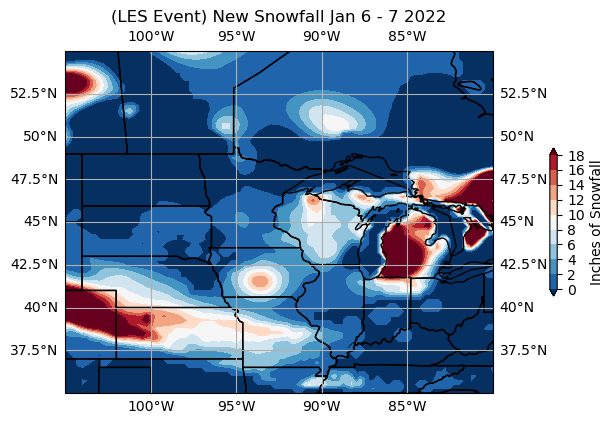

In [99]:
fig,ax = plt.subplots(figsize=(6, 4), subplot_kw={'projection': ccrs.PlateCarree()})
fig.tight_layout()
latmin_n = 20
latmax_n = 70
lonmin_n = -160
lonmax_n = -60
extent = [lonmin_n,lonmax_n,latmin_n,latmax_n]

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=1)
ax.add_feature(cfeature.STATES, linestyle='-', alpha=1)
ax.gridlines(draw_labels=True)
a = (dss2).plot.contourf(levels = np.arange(0,20,2),add_colorbar = False)
cb = plt.colorbar(a, shrink = 0.4,pad = 0.1)
plt.title('(LES Event) New Snowfall Jan 6 - 7 2022')
cb.set_label('Inches of Snowfall')

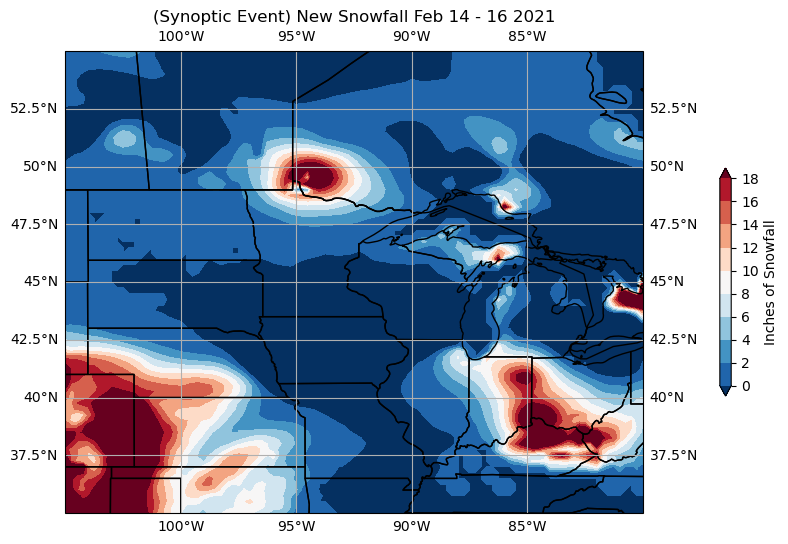

In [68]:

fig,ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})
fig.tight_layout()
latmin_n = 20
latmax_n = 70
lonmin_n = -160
lonmax_n = -60
extent = [lonmin_n,lonmax_n,latmin_n,latmax_n]

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=1)
ax.add_feature(cfeature.STATES, linestyle='-', alpha=1)
ax.gridlines(draw_labels=True)
a = (ds2).plot.contourf(levels = np.arange(0,20,2),add_colorbar = False)
cb = plt.colorbar(a, shrink = 0.4,pad = 0.1)
plt.title('(Synoptic Event) New Snowfall Feb 14 - 16 2021')
cb.set_label('Inches of Snowfall')

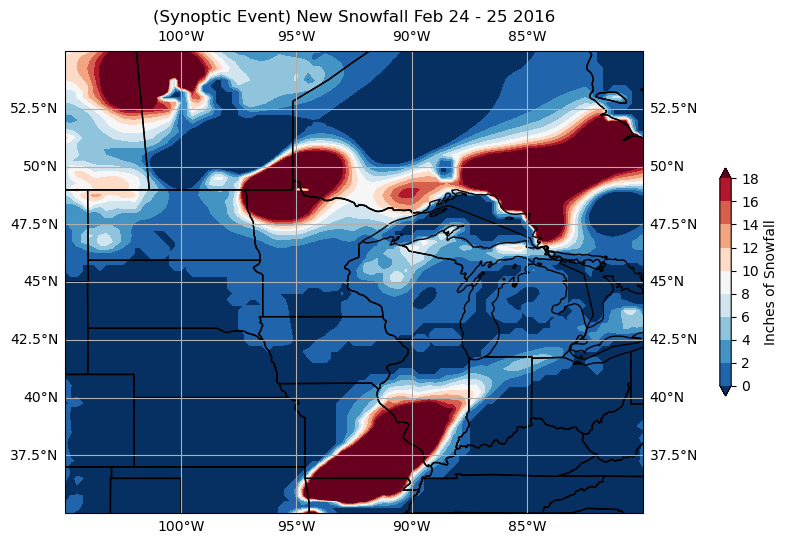

In [88]:
fig,ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})
fig.tight_layout()
latmin_n = 20
latmax_n = 70
lonmin_n = -160
lonmax_n = -60
extent = [lonmin_n,lonmax_n,latmin_n,latmax_n]

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=1)
ax.add_feature(cfeature.STATES, linestyle='-', alpha=1)
ax.gridlines(draw_labels=True)
a = (dss3).plot.contourf(levels = np.arange(0,20,2),add_colorbar = False)
cb = plt.colorbar(a, shrink = 0.4,pad = 0.1)
plt.title('(Synoptic Event) New Snowfall Feb 24 - 25 2016')
cb.set_label('Inches of Snowfall')